I'll use the QuantumOptics library which has a nice implementation of quantum objects in a way that keeps track of the bases. Below, we import this and redefine matrix squareroot and inverse to understand these objects, as well as defining the outer product when you multiply a ket by a bra. The documentation for this libary is here: https://qojulia.org/documentation/.

In [1]:
using QuantumOptics, SchattenNorms

import Base.*

# outer product
function *(x::QuantumOptics.states.Ket, y::QuantumOptics.states.Bra)
    return tensor(x, y)
end

# trace norm
import SchattenNorms.trnorm
trnorm(O::Operator) = trnorm(full(O.data))

import Base.LinAlg.sqrtm

function sqrtm(O::Operator)
    sdata = sqrtm(O.data);
    bl = O.basis_l;
    br = O.basis_r;
    DenseOperator(bl,br,sdata)
end

import Base.inv

function inv(O::Operator)
    idata = inv(O.data);
    bl = O.basis_l;
    br = O.basis_r;
    DenseOperator(bl,br,idata)
end

inv (generic function with 31 methods)

Next, we will define random objects; points on the simplex, density matrices (dm), and unitaries.

In [2]:
function randsimplexpt(d)
  # % function z=randsimplexpt(d)
  # % draw from a uniform distribution on the
  # % standard d+1-simplex; thus z>=0 and sum(z)=1
  # %From Koenraad Audenaert's MATLAB implementation

  if d==1
      z= 1;
  else
      z=zeros(d);
      w=sort(rand(d-1));
      z[1]=w[1];
      for k= 2:d-1
          z[k]=w[k]-w[k-1];
      end
      z[d]=1-w[d-1];
  end
  return z
end



# make a random density matrix by a convex combination of pure states
function randdm(b::Basis)
    d = reduce(*,1,b.shape);
    # d^2+1 for Catheodory...
    probs = randsimplexpt(d^2+1);
    sum( j -> probs[j]*dm(randstate(b)), 1:d^2+1)
end


# Following Maris: http://home.lu.lv/~sd20008/papers/essays/Random%20unitary%20[paper].pdf
function randUnitary(basis::Basis)
    d = reduce(*,1,basis.shape);
    RG = randn(d,d) + im*randn(d,d)
    Q,R = qr(RG);
    r = diag(R)
    L = diagm(r./abs.(r));
    DenseOperator(basis,basis,Q*L)
end

randUnitary (generic function with 1 method)

Now we define a system and environment, in the language of the quantum optics package.

In [3]:
dS=2 # system dimension
dE=2 # environment dimension

bS = FockBasis(dS-1)
bE = FockBasis(dE-1)
bSE = bS ⊗ bE
ketS(i) = basisstate(bS, i+1)
ketE(i) = basisstate(bE, i+1)

ketE (generic function with 1 method)

Next, we will define functions related to repeated interaction systems.

In [4]:
# we'll define a reduced dynamics object that holds the unitary U, the state xi,
# the actual "superoperator" L (which you can multiply on density matrices), and
# the Kraus operators K
# The reduced dynamics object depends on what you will measure, Y,
# because the choice of Kraus operators does. 
struct ReducedDynamics
    U::Operator
    xi::Operator
    Y::Operator
    v::Vector{Float64}
    L::SuperOperator
    K::Vector{DenseOperator}
end


# Given an "action", that is a function to map the input of the superoperator
# to the output, it constructs the matrix representation by acting on the basis
function supOpfromAction(action, basis)
    matBasis(i,j) = basisstate(basis,i) * dagger(basisstate(basis,j));
    d = length( basisstate(basis,1));
    data = Matrix{Complex128}(d^2,d^2);
    for i=1:d
    for j = 1:d
        data[:, sub2ind((d, d), i, j)] = reshape(action(matBasis(i,j)).data, d^2);
    end
    end
    DenseSuperOperator((basis,basis), (basis,basis), data)
end


# use the basis of the measurement Y
function Kraus(U, xi, Y, alpha)
    evals,estates = eigenstates(Y);
    matBasisE(i,j) = estates[i] * dagger(estates[j]);
    ex = expm(alpha*Y/2);
    mex = expm(-alpha*Y/2)
    K(i,j) = ptrace( (identityoperator(bS) ⊗ matBasisE(i,j))*(identityoperator(bS) ⊗ ex) * U * (identityoperator(bS) ⊗ mex) * (identityoperator(bS) ⊗ sqrtm(xi)), 2);
    return vec([K(i,j) for i = 1: dE, j = 1:dE])
end

Kraus(U, xi, Y)= Kraus(U, xi, Y, 0)

function getv(Y)
    evals,estates = eigenstates(Y);
    vec([exp(evals[j]-evals[i]) for i=1:length(evals), j=1:length(evals)])
end

# make a reduced dynamics object from U and xi by computing the reduced dynamics
# superoperator and the Kraus operators
function ReducedDynamics(U, xi, Y)
    action = x -> ptrace(U * (x ⊗ xi) * dagger(U),2)
    basis = bS;
    L = supOpfromAction(action, basis);
    ReducedDynamics(U, xi, Y, getv(Y), L, Kraus(U, xi, Y))
end

# in the following, we will only work with the Kraus operators.
function actionFromK(K::Vector{DenseOperator})
    x -> sum( i-> K[i] * x * dagger(K[i]), 1 : length(K))
end

actionFromK (generic function with 1 method)

Matrix representations are tricky, so let us check that our resulting superoperator agrees with its action on a basis.

In [5]:
# test that we got the indices right
function testSupOp(action, op)
  basis = op.basis_l[1];
  matBasis(i,j) = basisstate(basis,i) * dagger(basisstate(basis,j));
  d = length(basisstate(basis,1));
  sum([trnorm(action(matBasis(i,j)) - op * matBasis(i,j)) for i = 1:d, j= 1:d])
end

# test that we Kraus operator right
function testKrausAction(action, K)
    basis = K[1].basis_l;
  matBasis(i,j) = basisstate(basis,i) * dagger(basisstate(basis,j));
  d = length(basisstate(basis,1));
    aK = actionFromK(K);
  sum([trnorm(action(matBasis(i,j)) - aK( matBasis(i,j))) for i = 1:d, j= 1:d])
end

total = 0;
for k = 1:100
U = randUnitary(bSE);
xi = randdm(bE);
Y = rand()*xi
RD = ReducedDynamics(U, xi, Y);
action = x -> ptrace(U * (x ⊗ xi) * dagger(U),2);
total = total+ testSupOp(action, RD.L) + testKrausAction(action,RD.K);
end
println("The total norm discrepancy is $(total)")

The total norm discrepancy is 2.0752313254983958e-13


Now we make a function to get the Kraus operators and use them to find things to define the map T.

In [6]:
# get the index corresponding to the eigenvalue which is the spectral radius
function getind(evals::Vector{Complex128})
    tol = 10e-13;
    # find the indices with large imaginary part or negative real part
    bad_inds = find(x -> ~((abs(imag(x)) < tol) && (real(x) > 0)), evals);
    for j in bad_inds
    evals[j] = 0;
    end
    indmax(real(evals))
end

# get the real, positive eigenvalue
function getlambda(K::Vector{DenseOperator})
    L_action = actionFromK(K);
    L = supOpfromAction(L_action, bS);
    evals = eigvals(L.data);
    ind = getind(evals);
    
    real(evals[ind])
end

# get the invariant state
function getrho(K::Vector{DenseOperator})
  L_action = actionFromK(K);
  L = supOpfromAction(L_action, bS);

  evals,evecs = eig(L.data);
  ind = getind(evals);

  rho_data = reshape(evecs[:,ind], (dS, dS));

  rho_unnorm = DenseOperator(bS,bS, rho_data)
  rho = normalize(rho_unnorm)
  rho = (rho + dagger(rho) ) /2
end

# get the eigenvector for the dual map
function getI(K::Vector{DenseOperator})
  Lstar_action = actionFromK(vec(dagger.(K)));
  Lstar = supOpfromAction(Lstar_action, bS);

  evals,evecs = eig(Lstar.data);
  ind = getind(evals);
  I_data = reshape(evecs[:,ind], (dS, dS));
  I_data = (I_data + ctranspose(I_data))/2

    if (first(eigvals(I_data)) < 0)
        I_data = -1*I_data;
    end
    
  rho = getrho(K);
  I_unnorm = DenseOperator(bS,bS, I_data)
  I_norm = I_unnorm / trace(I_unnorm * rho)
end



# implement the map T
function T(K, v, alpha)

  # Kraus operators of the deformed map
  K_deformed = v.^(alpha/2) .* K;

  lambda_alpha = getlambda(K_deformed);
  I_alpha = getI(K_deformed);
  I_alpha_sq = sqrtm(I_alpha);
  I_alpha_msq = inv(I_alpha_sq);
  const_alpha =  v.^(alpha/2) ./ sqrt(lambda_alpha);

  K_hat = [ const_alpha[i] * I_alpha_sq * K[i] * I_alpha_msq  for i = 1:length(K)]
end

T (generic function with 1 method)

We define the quantities for our 2x2 examples:

In [7]:
a = destroy(bS)
b = destroy(bE)
vrw = a ⊗ dagger(b) + dagger(a) ⊗ b
vfull = (a + dagger(a)) ⊗ (b + dagger(b))
Isys = identityoperator(bS)
Ienv = identityoperator(bE)

E = .5;
E0 = 0.8;
hsys = E*dagger(a)*a
henv = E0*dagger(b)*b
lambda = 1;


Let's make a function to make random RIS, and to get the function which gives the set of eigenvalues of the T-transformed reduced dynamics as a function of alpha.

In [8]:
function makeRandomTRIExample()
    Isys = identityoperator(bS)
    Ienv = identityoperator(bE)


    hsys = rand(dS,dS)
    hsys = hsys + transpose(hsys)
    hsys = DenseOperator(bS,bS,hsys);

    henv = rand(dE,dE)
    henv = henv + transpose(henv)
    henv = DenseOperator(bE,bE,henv);

    v = rand(dS*dE,dS*dE)
    v = v + transpose(v)
    v = DenseOperator(bSE,bSE,v);

    h = hsys ⊗ Ienv + Isys ⊗ henv + v
    tau = 1;
    U = expm(- im*tau*h)

    beta = 3;
    xi = expm(- full(beta*henv))
    normalize!(xi)
    Y = full(beta*henv)


    RD = ReducedDynamics(U,xi, Y);
    return RD
end

function getTevalsfn(RD) 
    kraus = RD.K;
    v = RD.v;
    function getTevals(alpha)
        Tkraus = T(kraus, v, alpha)
        TL_action = actionFromK(Tkraus);
        TL = supOpfromAction(TL_action, bS);
        Tevals = eigvals(TL.data)
        return Tevals
    end
    return getTevals
end


getTevalsfn (generic function with 1 method)

Next, let us define some plotting functions and one to make a gif.

In [9]:
using Plots
pyplot()

function unitplot(evals, my_title)
    m = maximum(abs.(evals));
    range =  (-m - .1, m + .1);
    p = plot(evals,aspect_ratio=:equal, ann=[(-1.0,1.1, "iℝ"),(1.1,-1.0, "ℝ")], st = :scatter, xlim = range, ylim=range, aspect_ratio=:equal, title=my_title, ylabel="", xlabel="" )
    plot!(Plots.partialcircle(0,2π,200,m), color = :black, legend =:none)
    inline(p)
end

function makeGif(RD,alphas,name)
    Tevals = getTevalsfn(RD)
    anim = @animate for alpha=alphas
        unitplot(Tevals(alpha),"⍺ = "*rpad(alpha,4,0))
    end
    gif(anim, name * ".gif")
end


makeGif (generic function with 1 method)


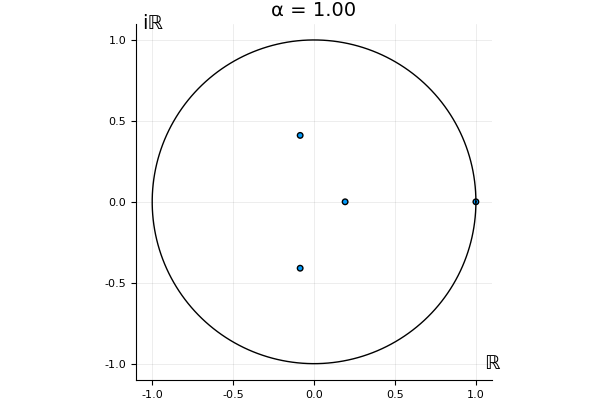

INFO: Saved animation to /store/CCIMI/eh540/Dropbox (Cambridge University)/Julia/T-transform/randomTRIexample18.gif


In [10]:
alphas=0:.05:1;
for j=1:18
    RD = makeRandomTRIExample()
    name = "randomTRIexample" * string(j);
    makeGif(RD,alphas,name);
end

In [11]:
h = hsys ⊗ Ienv + Isys ⊗ henv + lambda*vfull
h = full(h)
tau = .5;
U = expm(- im*tau*h)

beta = .0030;
xi = expm(- full(beta*henv))
normalize!(xi)
Y = full(beta*henv)


RDfd = ReducedDynamics(U,xi, Y);



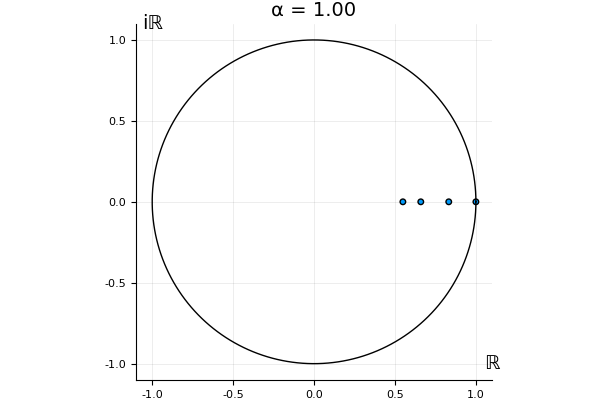

INFO: Saved animation to /store/CCIMI/eh540/Dropbox (Cambridge University)/Julia/T-transform/full-dipole.gif


In [12]:
makeGif(RDfd,alphas,"full-dipole");

In [13]:
h = hsys ⊗ Ienv + Isys ⊗ henv + lambda*vrw
h = full(h)
tau = .5;
U = expm(- im*tau*h)

beta = .0030;
xi = expm(- full(beta*henv))
normalize!(xi)
Y = full(beta*henv)

RDrw = ReducedDynamics(U,xi, Y);



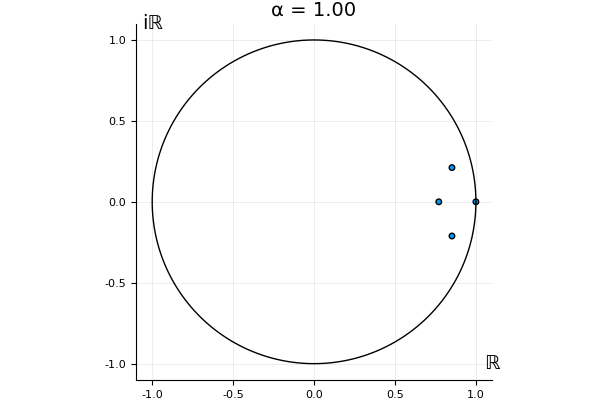

INFO: Saved animation to /store/CCIMI/eh540/Dropbox (Cambridge University)/Julia/T-transform/rw.gif


In [14]:
makeGif(RDrw,alphas,"rw");